In [ ]:
# Environment Setup and Kernel Restart
# This cell performs a forced installation of specific library versions to create a
# stable and reproducible environment, resolving potential binary incompatibility
# issues within the Colab runtime. The process involves uninstalling the default
# NumPy, then installing a known-compatible set of libraries.
# The cell concludes by programmatically restarting the kernel to ensure that the
# new libraries are loaded correctly in the new session.

!pip uninstall -y numpy
!pip install -q numpy==1.24.4

!pip install -q scikit-learn==1.3.2 scikit-learn-extra==0.3.0 matplotlib seaborn

# Automatically restart the Python kernel to apply changes.
import os
os.kill(os.getpid(), 9)

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 55.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 37.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Cella 1: Mounts the user's Google Drive to the Colab runtime for persistent storage.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Sets up project paths and global hyperparameters.

# --- Library Imports ---

import torch
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# --- Main Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
project_path = '/content/drive/MyDrive/DLAI_Project_4' # Assicurati che questo sia il tuo percorso

# Add the project folder to Python's path to allow module imports
if project_path not in sys.path:
    sys.path.append(project_path)

# Create results directory if it doesn't exist
os.makedirs(os.path.join(project_path, 'results'), exist_ok=True)

print(f"Project setup complete. Using device: {DEVICE}")

Project setup complete. Using device: cuda


In [ ]:
# Loads and prepares the MNIST dataset.
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(
    root=os.path.join(project_path, 'data'),
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root=os.path.join(project_path, 'data'),
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
full_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
# Defines and trains a continuous VAE that outputs a grid of latent vectors.

from torch import nn

# --- GridVAE Definition ---
class GridVAE(nn.Module):
    def __init__(self, embedding_dim=64):
        super(GridVAE, self).__init__()
        self.embedding_dim = embedding_dim
        # The encoder produces a 64x7x7 grid
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            # Two heads: one for mu, one for log_var
            nn.Conv2d(64, embedding_dim * 2, kernel_size=3, stride=1, padding=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1) # Split channels into mu and log_var
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# --- Training ---
print("Training GridVAE (Phase 1 of Method A)...")
grid_vae = GridVAE().to(DEVICE)
grid_vae_optimizer = optim.Adam(grid_vae.parameters(), lr=LEARNING_RATE)

# --- Define VAE loss function here for clarity ---
def vae_loss_function(recon_x, x, mu, log_var):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kld

epochs=20

for epoch in range(1, epochs+1):
    grid_vae.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(DEVICE)
        grid_vae_optimizer.zero_grad()
        recon_batch, mu, logvar = grid_vae(data)

        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        grid_vae_optimizer.step()
        train_loss += loss.item()


    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> GridVAE Epoch: {epoch} Average loss: {avg_loss:.4f}')

grid_vae_save_path = os.path.join(project_path, 'results', 'grid_vae.pt')
torch.save(grid_vae.state_dict(), grid_vae_save_path)
print(f"GridVAE trained and saved to: {grid_vae_save_path}")

Training GridVAE (Phase 1 of Method A)...
====> GridVAE Epoch: 1 Average loss: 197.7992
====> GridVAE Epoch: 2 Average loss: 139.3813
====> GridVAE Epoch: 3 Average loss: 131.4309
====> GridVAE Epoch: 4 Average loss: 128.8904
====> GridVAE Epoch: 5 Average loss: 127.6394
====> GridVAE Epoch: 6 Average loss: 126.7697
====> GridVAE Epoch: 7 Average loss: 126.0731
====> GridVAE Epoch: 8 Average loss: 125.6121
====> GridVAE Epoch: 9 Average loss: 125.1958
====> GridVAE Epoch: 10 Average loss: 124.7542
====> GridVAE Epoch: 11 Average loss: 124.3381
====> GridVAE Epoch: 12 Average loss: 124.1206
====> GridVAE Epoch: 13 Average loss: 123.5554
====> GridVAE Epoch: 14 Average loss: 123.1515
====> GridVAE Epoch: 15 Average loss: 122.8050
====> GridVAE Epoch: 16 Average loss: 122.4136
====> GridVAE Epoch: 17 Average loss: 122.2428
====> GridVAE Epoch: 18 Average loss: 122.0580
====> GridVAE Epoch: 19 Average loss: 121.8189
====> GridVAE Epoch: 20 Average loss: 121.7056
GridVAE trained and saved t

In [ ]:
# A Posteriori Geodesic Clustering and Quantization
# This cell implements the core of the innovative approach (Method A). It takes the
# continuous latent space from the trained GridVAE and creates a discrete codebook
# using a geodesic distance metric, finally quantizing the entire dataset.

from sklearn.neighbors import kneighbors_graph, KNeighborsClassifier
from scipy.sparse.csgraph import shortest_path, connected_components
from sklearn_extra.cluster import KMedoids

# --- 1. Extract All Latent Vectors from the GridVAE ---
print("Extracting all latent vectors from all grids...")
grid_vae.eval()
all_vectors = []
with torch.no_grad():
    for data, _ in full_train_loader:
        data = data.to(DEVICE)
        _, mu, _ = grid_vae(data)
        # Reshape from (B, C, H, W) to (B*H*W, C) to create a list of vectors
        all_vectors.append(mu.permute(0, 2, 3, 1).reshape(-1, grid_vae.embedding_dim).cpu())
all_vectors = torch.cat(all_vectors, dim=0).numpy()
print(f"Total vectors extracted: {all_vectors.shape[0]}")


# --- 2. Build Geodesic Metric on a Landmark Subset ---
# A subset of vectors ("landmarks") is sampled to make the geodesic distance
# calculation computationally feasible.
SAMPLE_SIZE = 10000
N_NEIGHBORS = 15
np.random.seed(42)
landmarks = all_vectors[np.random.choice(len(all_vectors), SAMPLE_SIZE, replace=False)]

# Build a k-NN graph on the landmarks, where edge weights are Euclidean distances.
print(f"Building k-NN graph on {SAMPLE_SIZE} landmarks...")
knn_graph = kneighbors_graph(
    landmarks,
    n_neighbors=N_NEIGHBORS,
    mode='distance',
    include_self=False,
    n_jobs=-1
)

# Validate graph connectivity to ensure a meaningful distance metric.
n_components, _ = connected_components(knn_graph, directed=False)
if n_components > 1:
    print(f"Warning: Graph has {n_components} components.")

# Calculate the all-pairs shortest path on the graph (geodesic distance).
print("Calculating geodesic distances between landmarks...")
geo_dists = shortest_path(
    knn_graph,
    method='D',
    directed=False
)
# Handle potential disconnected components by replacing infinite distances.
max_finite_dist = np.nanmax(geo_dists[np.isfinite(geo_dists)])
geo_dists[np.isinf(geo_dists)] = max_finite_dist * 1.1


# --- 3. Perform Geodesic Clustering to Create the Codebook ---
print("Clustering landmarks with KMedoids using the precomputed geodesic distance matrix...")
N_CODES_A = 128
# KMedoids is used as it can accept a precomputed distance matrix.
kmedoids = KMedoids(
    n_clusters=N_CODES_A,
    metric='precomputed',
    random_state=42
).fit(geo_dists)

# The final codebook consists of the landmark vectors that were chosen as medoids.
aproach_A_codebook = landmarks[kmedoids.medoid_indices_]
landmark_labels = kmedoids.labels_
print("✅ A posteriori geodesic codebook for Method A created.")


# --- 4. Quantize the Full Dataset ---
print("Quantizing all ~3 million vectors based on nearest landmark assignment...")
# To efficiently assign each of the ~3M vectors to a geodesic cluster, we find its
# nearest landmark in the original Euclidean space and assign it that landmark's label.
# A KNeighborsClassifier with k=1 is a highly efficient way to implement this.
knn_quantizer = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn_quantizer.fit(landmarks, landmark_labels)

# Process in batches to manage memory.
batch_size = 50000
codes_A = []
for i in range(0, len(all_vectors), batch_size):
    batch_codes = knn_quantizer.predict(all_vectors[i:i+batch_size])
    codes_A.append(batch_codes)
codes_A = np.concatenate(codes_A)

# Reshape the flat list of codes back into the original grid structure.
codes_A_dataset = torch.from_numpy(codes_A).long().view(-1, 7, 7)
print(f" Dataset of geodesic discrete codes created. Shape: {codes_A_dataset.shape}")

Extracting all latent vectors from all grids...
Total vectors extracted: 2940000
Building k-NN graph on 10000 landmarks...
Calculating geodesic distances between landmarks...
Clustering landmarks with KMedoids using the precomputed geodesic distance matrix...
✅ A posteriori geodesic codebook for Method A created.
Quantizing all ~3 million vectors based on nearest landmark assignment...
 Dataset of geodesic discrete codes created. Shape: torch.Size([60000, 7, 7])


In [ ]:
# Trains a Transformer on the discrete codes from Method A.
# This cell defines the autoregressive prior, prepares the discrete code data,
# and executes the training loop for the innovative pipeline.


import math
# (Definition of PositionalEncoding and GenerativeTransformer classes)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x): return x + self.pe[:, :x.size(1)]
class GenerativeTransformer(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=128, num_heads=4, num_layers=3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.code_embedding = nn.Embedding(num_embeddings + 1, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim)
        layer = nn.TransformerDecoderLayer(d_model=embedding_dim, nhead=num_heads, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embedding_dim, num_embeddings)
    def forward(self, tgt, memory):
        tgt_emb = self.pos_encoder(self.code_embedding(tgt) * math.sqrt(self.embedding_dim))
        mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        return self.fc_out(self.transformer_decoder(tgt_emb, memory, tgt_mask=mask))

# --- Data Preparation ---
print("Preparing data for the Transformer (Method A)...")
codes_reshaped = codes_A_dataset.view(codes_A_dataset.size(0), -1)
start_token = N_CODES_A
start_tokens = torch.full((codes_reshaped.size(0), 1), start_token, dtype=torch.long)
transformer_input = torch.cat([start_tokens, codes_reshaped], dim=1)[:, :-1]
transformer_target = codes_reshaped
transformer_loader = DataLoader(TensorDataset(transformer_input, transformer_target), batch_size=BATCH_SIZE, shuffle=True)

# --- Model Training ---
print("Training Transformer for Method A...")
transformer_A = GenerativeTransformer(num_embeddings=N_CODES_A).to(DEVICE)
transformer_A_optimizer = optim.Adam(transformer_A.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()
epochs=20

for epoch in range(1, epochs + 1):
    transformer_A.train()
    total_loss = 0
    for input_seq, target_seq in transformer_loader:
        input_seq, target_seq = input_seq.to(DEVICE), target_seq.to(DEVICE)
        transformer_A_optimizer.zero_grad()


        # The dummy memory's dimension must match the transformer's embedding_dim.
        dummy_memory = torch.zeros(input_seq.size(0), input_seq.size(1), transformer_A.embedding_dim).to(DEVICE)

        output = transformer_A(input_seq, dummy_memory)

        loss = loss_fn(output.reshape(-1, N_CODES_A), target_seq.reshape(-1))
        loss.backward()
        transformer_A_optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(transformer_loader)
    print(f'====> Transformer A Epoch: {epoch} Average loss: {avg_loss:.4f}')

print("\n✅ Transformer for Method A is trained.")

# --- Save the final trained model ---
transformer_A_save_path = os.path.join(project_path, 'results', 'transformer_A.pt')
torch.save(transformer_A.state_dict(), transformer_A_save_path)
print(f"✅ Transformer A model saved to: {transformer_A_save_path}")

Preparing data for the Transformer (Method A)...
Training Transformer for Method A...
====> Transformer A Epoch: 1 Average loss: 2.9215
====> Transformer A Epoch: 2 Average loss: 2.4643
====> Transformer A Epoch: 3 Average loss: 2.2817
====> Transformer A Epoch: 4 Average loss: 2.1722
====> Transformer A Epoch: 5 Average loss: 2.0869
====> Transformer A Epoch: 6 Average loss: 2.0172
====> Transformer A Epoch: 7 Average loss: 1.9624
====> Transformer A Epoch: 8 Average loss: 1.9187
====> Transformer A Epoch: 9 Average loss: 1.8848
====> Transformer A Epoch: 10 Average loss: 1.8561
====> Transformer A Epoch: 11 Average loss: 1.8315
====> Transformer A Epoch: 12 Average loss: 1.8114
====> Transformer A Epoch: 13 Average loss: 1.7939
====> Transformer A Epoch: 14 Average loss: 1.7788
====> Transformer A Epoch: 15 Average loss: 1.7644
====> Transformer A Epoch: 16 Average loss: 1.7532
====> Transformer A Epoch: 17 Average loss: 1.7421
====> Transformer A Epoch: 18 Average loss: 1.7317
====>

Generating images from your complete pipeline (Method A)...


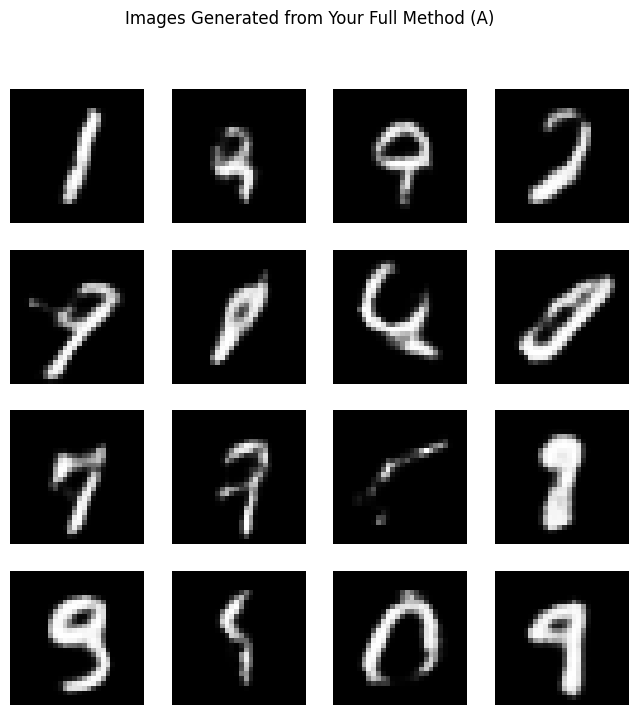

In [ ]:
# Generates final images using your full innovative pipeline.
print("Generating images from your complete pipeline (Method A)...")

transformer_A.eval()
aproach_A_codebook_tensor = torch.from_numpy(aproach_A_codebook).float().to(DEVICE)

# 1. Generate new code grids with the Transformer
generated_sequences = torch.full((16, 1), N_CODES_A, dtype=torch.long).to(DEVICE)
for _ in range(49): # 7*7
    with torch.no_grad():
        dummy_memory = torch.zeros(16, generated_sequences.size(1), 128).to(DEVICE)
        output = transformer_A(generated_sequences, dummy_memory)
        probs = F.softmax(output[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        generated_sequences = torch.cat([generated_sequences, next_token], dim=1)
generated_codes = generated_sequences[:, 1:].reshape(16, 7, 7)

# 2. Decode the grids into images using the GridVAE's decoder
with torch.no_grad():
    quantized_latents = F.embedding(generated_codes, aproach_A_codebook_tensor).permute(0, 3, 1, 2)
    generated_images_A_final = grid_vae.decoder(quantized_latents).cpu()

# 3. Visualize
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
plt.suptitle("Images Generated from Your Full Method (A)")
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images_A_final[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()

In [ ]:
# Defines and trains the VQ-VAE with the code resampling fix.

'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# LEARNING_RATE = 1e-3
# train_loader = ... (il tuo DataLoader per i dati di addestramento)

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim, self.num_embeddings, self.commitment_cost = embedding_dim, num_embeddings, commitment_cost
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
        self.register_buffer("ema_cluster_size", torch.zeros(num_embeddings))

    def forward(self, inputs):
        flat_input = inputs.view(-1, self.embedding_dim)
        distances = (
            torch.sum(flat_input**2, dim=1, keepdim=True)
            + torch.sum(self.embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, self.embedding.weight.t())
        )
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device).scatter_(1, encoding_indices, 1)
        quantized = torch.matmul(encodings, self.embedding.weight).view(inputs.shape)

        if self.training:
            self.ema_cluster_size = self.ema_cluster_size * 0.99 + (1 - 0.99) * torch.sum(encodings, 0)

        e_loss = F.mse_loss(quantized.detach(), inputs)
        q_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_loss + self.commitment_cost * e_loss
        quantized = inputs + (quantized - inputs).detach()

        return loss, quantized, encodings, encoding_indices

    def resample_dead_codes(self, inputs):
        if not self.training:
            return
        with torch.no_grad():
            dead_codes_mask = self.ema_cluster_size < 1e-4
            if not dead_codes_mask.any():
                return
            flat_inputs = inputs.view(-1, self.embedding_dim)
            random_inputs = flat_inputs[torch.randperm(flat_inputs.size(0))[:dead_codes_mask.sum()]]
            self.embedding.weight.data[dead_codes_mask] = random_inputs
            self.ema_cluster_size[dead_codes_mask] = 1.0


class VQVAE(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=64, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, embedding_dim, 3, 1, 1)
        )
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        vq_loss, quantized_z, _, _ = self.vq_layer(z)
        x_recon = self.decoder(quantized_z)
        return vq_loss, x_recon


# --- Training ---
print("Training VQ-VAE with resampling (Method B)...")


vq_model = VQVAE(num_embeddings=128, embedding_dim=64, commitment_cost=0.25).to(DEVICE)
vq_optimizer = optim.Adam(vq_model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, 21):  # 20 epochs
    vq_model.train()
    for data, _ in train_loader:
        data = data.to(DEVICE)
        vq_optimizer.zero_grad()
        z = vq_model.encoder(data)
        if epoch > 5:
            vq_model.vq_layer.resample_dead_codes(z)
        vq_loss, quantized_z, _, _ = vq_model.vq_layer(z)
        data_recon = vq_model.decoder(quantized_z)
        recon_loss = F.binary_cross_entropy(data_recon, data)
        total_loss = recon_loss + vq_loss
        total_loss.backward()
        vq_optimizer.step()

    print(f'====> VQ-VAE Epoch: {epoch} trained.')

print(f"✅ VQ-VAE trained.")
'''

'\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.optim as optim\n\n# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n# LEARNING_RATE = 1e-3\n# train_loader = ... (il tuo DataLoader per i dati di addestramento)\n\nclass VectorQuantizer(nn.Module):\n    def __init__(self, num_embeddings, embedding_dim, commitment_cost):\n        super(VectorQuantizer, self).__init__()\n        self.embedding_dim, self.num_embeddings, self.commitment_cost = embedding_dim, num_embeddings, commitment_cost\n        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)\n        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)\n        self.register_buffer("ema_cluster_size", torch.zeros(num_embeddings))\n\n    def forward(self, inputs):\n        flat_input = inputs.view(-1, self.embedding_dim)\n        distances = (\n            torch.sum(flat_input**2, dim=1, keepdim=True)\n            + torch.sum(s

In [ ]:
# VQ-VAE Model Definition
# This cell defines the architecture for the standard VQ-VAE baseline model.
# It uses a simplified, more stable implementation without code resampling,
# relying on the commitment_cost to regularize the codebook.

class VectorQuantizer(nn.Module):
    """
    The core VQ layer which maps continuous encoder outputs to a discrete codebook.
    """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        # The codebook is a learnable embedding layer.
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, inputs):
        # Flatten the input tensor from the encoder for distance calculation.
        flat_input = inputs.view(-1, self.embedding_dim)

        # Calculate Euclidean distances to all vectors in the codebook.
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        # Find the index of the closest codebook vector for each input vector.
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Retrieve the quantized vectors from the codebook.
        quantized = torch.matmul(encodings, self.embedding.weight).view(inputs.shape)

        # --- VQ Loss Calculation ---
        # Codebook Loss: Pushes the codebook vectors towards the encoder outputs.
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        # Commitment Loss: Pushes the encoder outputs to commit to a codebook vector.
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Use a straight-through estimator to pass gradients through the discrete step.
        quantized = inputs + (quantized - inputs).detach()

        return loss, quantized, encodings, encoding_indices

class VQVAE(nn.Module):
    """
    The main VQ-VAE model, combining a convolutional encoder, the VectorQuantizer layer,
    and a convolutional decoder.
    """
    def __init__(self, num_embeddings=128, embedding_dim=64, commitment_cost=0.5):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, embedding_dim, 3, 1, 1)
        )
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        # The data flow: encode -> quantize -> decode.
        z = self.encoder(x)
        vq_loss, quantized_z, _, _ = self.vq_layer(z)
        x_recon = self.decoder(quantized_z)
        return vq_loss, x_recon

print("VQ-VAE model is defined.")

VQ-VAE model is defined.


In [ ]:
# VQ-VAE Model Training
# This cell handles the initialization and training of the VQ-VAE model,


# --- 1. Initialization ---
# Instantiate the VQVAE model and the Adam optimizer.
vq_model = VQVAE(num_embeddings=128, embedding_dim=64, commitment_cost=0.5).to(DEVICE)
vq_optimizer = optim.Adam(vq_model.parameters(), lr=LEARNING_RATE)

# --- 2. Training Loop ---
print("Starting final, stable VQ-VAE training...")
VQ_VAE_EPOCHS = 20
for epoch in range(1, VQ_VAE_EPOCHS + 1):
    # Set the model to training mode for the current epoch.
    vq_model.train()
    train_loss = 0

    # Iterate over the dataset in batches.
    for data, _ in train_loader:
        data = data.to(DEVICE)
        vq_optimizer.zero_grad()

        # Forward pass: get reconstructions and the VQ loss from the model.
        vq_loss, data_recon = vq_model(data)

        # Calculate the total loss as a sum of reconstruction and VQ losses.
        recon_loss = F.binary_cross_entropy(data_recon.view(-1, 784), data.view(-1, 784), reduction='sum')
        total_loss = recon_loss + vq_loss

        # Backward pass: compute gradients and update model weights.
        total_loss.backward()
        vq_optimizer.step()

        train_loss += recon_loss.item()

    # Print the average reconstruction loss for the epoch.
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> VQ-VAE Epoch: {epoch} Average Reconstruction loss: {avg_loss:.4f}')

print(f"\n✅ VQ-VAE training finished.")

# --- 3. Save the final trained model ---
# The model's learned weights are saved for later use in generation and analysis.
vq_model_save_path = os.path.join(project_path, 'results', 'vq_model_stable.pt')
torch.save(vq_model.state_dict(), vq_model_save_path)
print(f"VQ-VAE model saved to: {vq_model_save_path}")

Starting final, stable VQ-VAE training...
====> VQ-VAE Epoch: 1 Average Reconstruction loss: 209.3966
====> VQ-VAE Epoch: 2 Average Reconstruction loss: 128.4361
====> VQ-VAE Epoch: 3 Average Reconstruction loss: 106.3726
====> VQ-VAE Epoch: 4 Average Reconstruction loss: 98.2924
====> VQ-VAE Epoch: 5 Average Reconstruction loss: 94.3555
====> VQ-VAE Epoch: 6 Average Reconstruction loss: 91.5993
====> VQ-VAE Epoch: 7 Average Reconstruction loss: 89.6975
====> VQ-VAE Epoch: 8 Average Reconstruction loss: 88.3010
====> VQ-VAE Epoch: 9 Average Reconstruction loss: 86.8806
====> VQ-VAE Epoch: 10 Average Reconstruction loss: 85.6399
====> VQ-VAE Epoch: 11 Average Reconstruction loss: 84.1095
====> VQ-VAE Epoch: 12 Average Reconstruction loss: 82.6578
====> VQ-VAE Epoch: 13 Average Reconstruction loss: 81.4906
====> VQ-VAE Epoch: 14 Average Reconstruction loss: 80.6333
====> VQ-VAE Epoch: 15 Average Reconstruction loss: 79.8283
====> VQ-VAE Epoch: 16 Average Reconstruction loss: 79.2313
====

Extracting codes from VQ-VAE for Transformer training...
Training Transformer for Method B...
====> Transformer B Epoch: 1 Average loss: 2.5964
====> Transformer B Epoch: 2 Average loss: 2.3887
====> Transformer B Epoch: 3 Average loss: 2.2022
====> Transformer B Epoch: 4 Average loss: 2.0168
====> Transformer B Epoch: 5 Average loss: 1.8871
====> Transformer B Epoch: 6 Average loss: 1.7992
====> Transformer B Epoch: 7 Average loss: 1.7354
====> Transformer B Epoch: 8 Average loss: 1.6839
====> Transformer B Epoch: 9 Average loss: 1.6428
====> Transformer B Epoch: 10 Average loss: 1.6083

✅ Transformer for Method B trained.
✅ Transformer B model saved to: /content/drive/MyDrive/DLAI_Project_4/results/transformer_B.pt

Generating images from Baseline Method (B)...


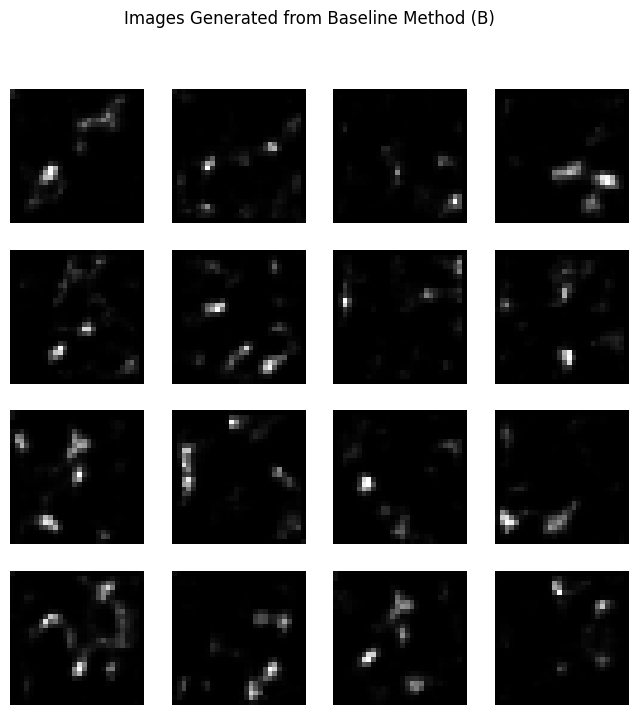

In [ ]:
# This cell implements the full pipeline for the VQ-VAE baseline (Method B).
# It performs three sequential tasks:
#   1. Extracts the discrete code grids from the trained VQ-VAE.
#   2. Trains a Generative Transformer on these codes.
#   3. Uses the trained Transformer to generate and visualize final image samples.

# 1. Extract Codes from VQ-VAE
print("Extracting codes from VQ-VAE for Transformer training...")
vq_model.eval()
all_indices = []
with torch.no_grad():
    for data, _ in full_train_loader:
        z = vq_model.encoder(data.to(DEVICE))
        _, _, _, encoding_indices = vq_model.vq_layer(z)
        all_indices.append(encoding_indices.view(-1, 7, 7).cpu())
codes_B_dataset = torch.cat(all_indices, dim=0)

# 2. Train Transformer on VQ-VAE codes
# (Re-using the same Transformer architecture definition from before)
print("Training Transformer for Method B...")
N_CODES_B = 128
codes_reshaped = codes_B_dataset.view(codes_B_dataset.size(0), -1)
start_token = N_CODES_B
start_tokens = torch.full((codes_reshaped.size(0), 1), start_token, dtype=torch.long)
transformer_input = torch.cat([start_tokens, codes_reshaped], dim=1)[:, :-1]
transformer_target = codes_reshaped
transformer_loader = DataLoader(TensorDataset(transformer_input, transformer_target), batch_size=BATCH_SIZE, shuffle=True)
transformer_B = GenerativeTransformer(num_embeddings=N_CODES_B).to(DEVICE)
transformer_B_optimizer = optim.Adam(transformer_B.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

epochs=20

for epoch in range(1, 11):
    transformer_B.train()
    total_loss = 0

    for input_seq, target_seq in transformer_loader:
        input_seq, target_seq = input_seq.to(DEVICE), target_seq.to(DEVICE)
        transformer_B_optimizer.zero_grad()

        dummy_memory = torch.zeros(input_seq.size(0), input_seq.size(1), 128).to(DEVICE)
        output = transformer_B(input_seq, dummy_memory)

        loss = loss_fn(output.reshape(-1, N_CODES_B), target_seq.reshape(-1))
        loss.backward()
        transformer_B_optimizer.step()
        total_loss += loss.item()

    # --- print average loss per epoch ---
    avg_loss = total_loss / len(transformer_loader)
    print(f'====> Transformer B Epoch: {epoch} Average loss: {avg_loss:.4f}')

print(f"\n✅ Transformer for Method B trained.")

# --- Save the final trained model ---
transformer_B_save_path = os.path.join(project_path, 'results', 'transformer_B.pt')
torch.save(transformer_B.state_dict(), transformer_B_save_path)
print(f"✅ Transformer B model saved to: {transformer_B_save_path}")


# 3. Generate Final Images with Method B
print("\nGenerating images from Baseline Method (B)...")
transformer_B.eval()
generated_sequences = torch.full((16, 1), N_CODES_B, dtype=torch.long).to(DEVICE)
for _ in range(49):
    with torch.no_grad():
        dummy_memory = torch.zeros(16, generated_sequences.size(1), 128).to(DEVICE)
        output = transformer_B(generated_sequences, dummy_memory)
        probs = F.softmax(output[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        generated_sequences = torch.cat([generated_sequences, next_token], dim=1)
generated_codes = generated_sequences[:, 1:].reshape(16, 7, 7)
with torch.no_grad():
    codebook_vectors = vq_model.vq_layer.embedding.weight.data
    quantized_latents = F.embedding(generated_codes, codebook_vectors).permute(0, 3, 1, 2)
    generated_images_B_final = vq_model.decoder(quantized_latents).cpu()

# 4. Visualize
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
plt.suptitle("Images Generated from Baseline Method (B)")
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images_B_final[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()

Comparing reconstruction quality...

--- Quantitative Comparison (Lower is Better) ---
Method A (Geodesic) - Reconstruction MSE: 0.016125
Method B (VQ-VAE)   - Reconstruction MSE: 0.011385


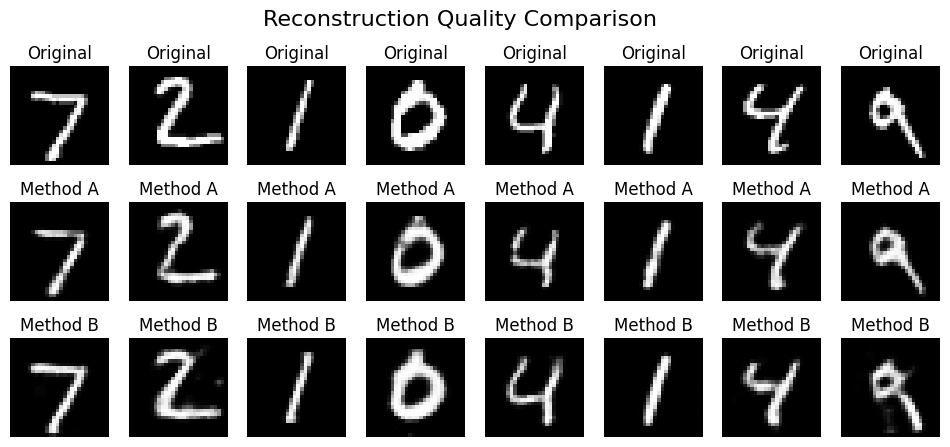

In [ ]:
# Reconstruction Quality Comparison
# This cell compares the reconstruction performance of the two primary methods:
# Method A (a posteriori geodesic quantization) and Method B (end-to-end VQ-VAE).
# The comparison is performed both quantitatively (MSE) and qualitatively (visual plot).

from sklearn.metrics import pairwise_distances_argmin_min

print("Comparing reconstruction quality...")

# Ensure both trained models are in evaluation mode.
# In a new session, these models would first be loaded from their saved files.
grid_vae.eval()
vq_model.eval()

# Fetch a single batch of images from the test set for comparison.
images, _ = next(iter(test_loader))
images = images.to(DEVICE)

# --- 1. Generate Reconstructions for Both Methods ---
with torch.no_grad():
    # --- Method A (Geodesic) Reconstruction ---
    # The process involves encoding, quantizing to the a posteriori codebook, and decoding.
    _, mu_A, _ = grid_vae(images)
    vectors_A = mu_A.permute(0, 2, 3, 1).reshape(-1, grid_vae.embedding_dim).cpu().numpy()
    codes_A, _ = pairwise_distances_argmin_min(vectors_A, aproach_A_codebook)
    quantized_vectors_A = torch.from_numpy(aproach_A_codebook[codes_A]).float().to(DEVICE)
    quantized_grid_A = quantized_vectors_A.reshape(images.shape[0], 7, 7, -1).permute(0, 3, 1, 2)
    recon_A = grid_vae.decoder(quantized_grid_A).cpu()

    # --- Method B (VQ-VAE) Reconstruction ---
    # This is a direct forward pass through the end-to-end trained model.
    _, recon_B_gpu = vq_model(images)
    recon_B = recon_B_gpu.cpu()

# --- 2. Quantitative Comparison (Mean Squared Error) ---
# Calculate the MSE between the original images and the reconstructions for both methods.
mse_A = F.mse_loss(recon_A, images.cpu())
mse_B = F.mse_loss(recon_B, images.cpu())

print(f"\n--- Quantitative Comparison (Lower is Better) ---")
print(f"Method A (Geodesic) - Reconstruction MSE: {mse_A:.6f}")
print(f"Method B (VQ-VAE)   - Reconstruction MSE: {mse_B:.6f}")


# --- 3. Qualitative Visual Comparison ---
# Plot the original images alongside the reconstructions from both methods.
n_images = 8
fig, axes = plt.subplots(nrows=3, ncols=n_images, figsize=(12, 5))
plt.suptitle("Reconstruction Quality Comparison", fontsize=16)
for i in range(n_images):
    # Top row: Original images
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    # Middle row: Method A reconstructions
    axes[1, i].imshow(recon_A[i].squeeze(), cmap='gray')
    axes[1, i].set_title("Method A")
    axes[1, i].axis('off')
    # Bottom row: Method B reconstructions
    axes[2, i].imshow(recon_B[i].squeeze(), cmap='gray')
    axes[2, i].set_title("Method B")
    axes[2, i].axis('off')
plt.show()

In [ ]:
# Perplexity comparison

print("Comparing the perplexity of the two generative priors (Transformers)...")

# --- Function to calculate perplexity ---
def calculate_perplexity(model, loader, loss_fn, num_embeddings):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for input_seq, target_seq in loader:
            input_seq, target_seq = input_seq.to(DEVICE), target_seq.to(DEVICE)
            dummy_memory = torch.zeros(input_seq.size(0), input_seq.size(1), model.embedding_dim).to(DEVICE)
            output = model(input_seq, dummy_memory)
            loss = loss_fn(output.reshape(-1, num_embeddings), target_seq.reshape(-1))
            total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    perplexity = math.exp(avg_loss)
    return perplexity

# --- Create validation sets for both code types ---
# Method A (Geodesic)
codes_A_reshaped = codes_A_dataset.view(codes_A_dataset.size(0), -1)
start_tokens_A = torch.full((codes_A_reshaped.size(0), 1), N_CODES_A, dtype=torch.long)
input_A = torch.cat([start_tokens_A, codes_A_reshaped], dim=1)[:, :-1]
target_A = codes_A_reshaped
# Use last 10k samples as validation set
val_loader_A = DataLoader(TensorDataset(input_A[50000:], target_A[50000:]), batch_size=BATCH_SIZE)

# Method B (VQ-VAE)
# First, extract all codes for Method B
vq_model.eval()
all_indices_B = []
with torch.no_grad():
    for data, _ in full_train_loader:
        z = vq_model.encoder(data.to(DEVICE))
        _, _, _, encoding_indices = vq_model.vq_layer(z)
        all_indices_B.append(encoding_indices.view(-1, 7, 7).cpu())
codes_B_dataset = torch.cat(all_indices_B, dim=0)

codes_B_reshaped = codes_B_dataset.view(codes_B_dataset.size(0), -1)
start_tokens_B = torch.full((codes_B_reshaped.size(0), 1), 128, dtype=torch.long)
input_B = torch.cat([start_tokens_B, codes_B_reshaped], dim=1)[:, :-1]
target_B = codes_B_reshaped
# Use last 10k samples as validation set
val_loader_B = DataLoader(TensorDataset(input_B[50000:], target_B[50000:]), batch_size=BATCH_SIZE)


# --- Calculate Perplexity for both trained Transformers ---
# Assumes 'transformer_A' and 'transformer_B' are trained and in memory
perplexity_A = calculate_perplexity(transformer_A, val_loader_A, nn.CrossEntropyLoss(), N_CODES_A)
perplexity_B = calculate_perplexity(transformer_B, val_loader_B, nn.CrossEntropyLoss(), 128)


print(f"\n--- Quantitative Comparison (Lower is Better) ---")
print(f"Method A (Geodesic) - Transformer Perplexity: {perplexity_A:.4f}")
print(f"Method B (VQ-VAE)   - Transformer Perplexity: {perplexity_B:.4f}")

Comparing the perplexity of the two generative priors (Transformers)...

--- Quantitative Comparison (Lower is Better) ---
Method A (Geodesic) - Transformer Perplexity: 4.9448
Method B (VQ-VAE)   - Transformer Perplexity: 4.2686


Comparing codebook utilization for Method A vs. Method B...

--- Quantitative Comparison ---
Method A (Geodesic):   128 / 128 codes used (100.0%)
Method B (VQ-VAE):     15 / 128 codes used (11.7%)


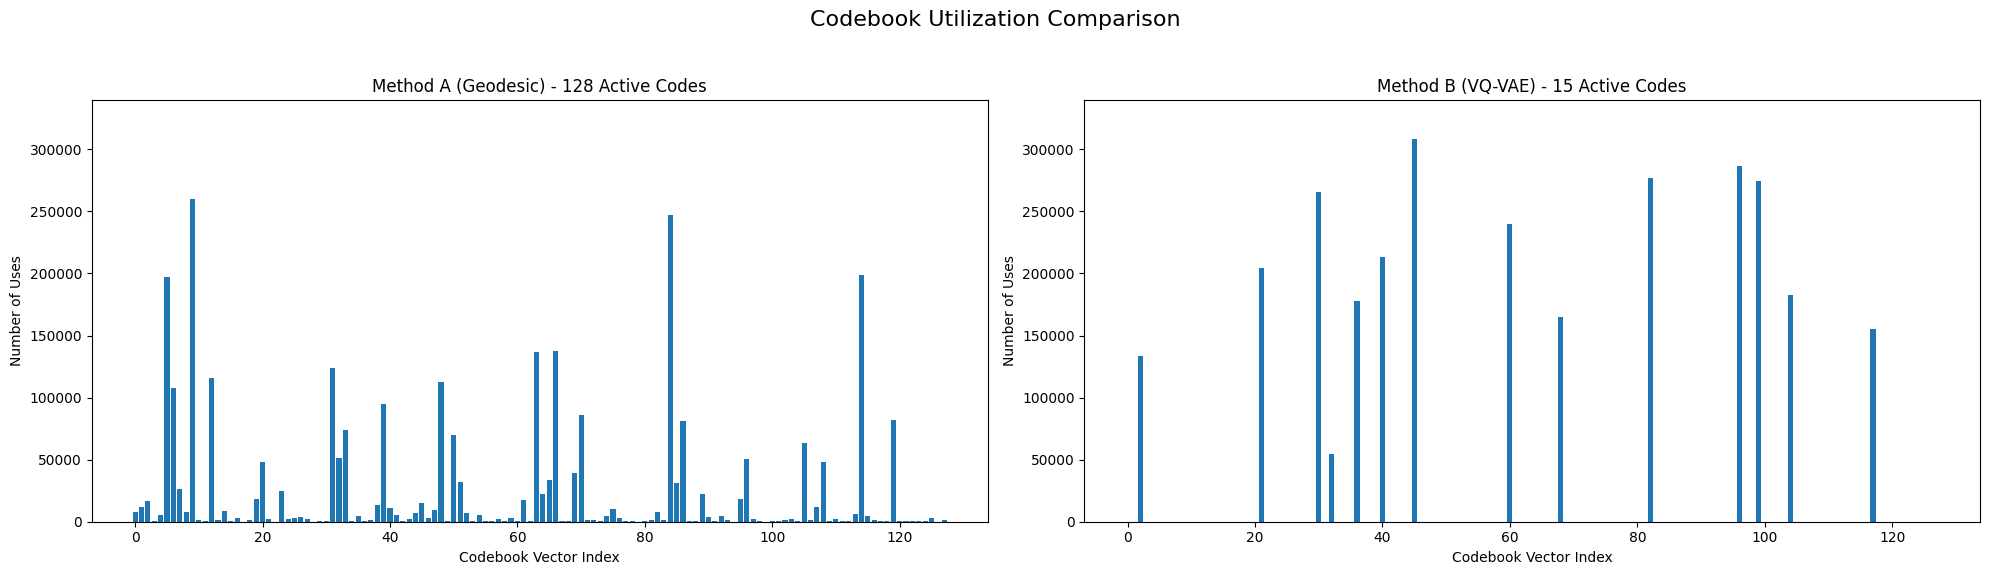

In [ ]:
# Comparison Cell: Codebook Utilization

print("Comparing codebook utilization for Method A vs. Method B...")

# --- Load the discrete code datasets from both methods ---
# Method A (Geodesic)
# Assumes 'codes_A_dataset' is in memory from the previous cell.
# If not, you would load it: codes_A_dataset = torch.load('path/to/codes_A_dataset.pt')

# Method B (VQ-VAE)
# Assumes 'codes_B_dataset' is in memory from the previous cell.
# If not, you would load it: codes_B_dataset = torch.load('path/to/codes_B_dataset.pt')


# --- Calculate usage statistics for Method A ---
codes_A_flat = codes_A_dataset.flatten()
counts_A = torch.bincount(codes_A_flat, minlength=N_CODES_A)
active_codes_A = torch.sum(counts_A > 0).item()

# --- Calculate usage statistics for Method B ---
codes_B_flat = codes_B_dataset.flatten()
counts_B = torch.bincount(codes_B_flat, minlength=128) # Assuming N_CODES_B is 128
active_codes_B = torch.sum(counts_B > 0).item()


# --- Print the quantitative comparison ---
print("\n--- Quantitative Comparison ---")
print(f"Method A (Geodesic):   {active_codes_A} / {N_CODES_A} codes used ({active_codes_A / N_CODES_A:.1%})")
print(f"Method B (VQ-VAE):     {active_codes_B} / 128 codes used ({active_codes_B / 128:.1%})")


# --- Create the side-by-side plots for visual comparison ---
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.suptitle("Codebook Utilization Comparison", fontsize=16)

# Plot for Method A
axes[0].bar(range(N_CODES_A), counts_A.cpu().numpy())
axes[0].set_title(f"Method A (Geodesic) - {active_codes_A} Active Codes")
axes[0].set_xlabel("Codebook Vector Index")
axes[0].set_ylabel("Number of Uses")
axes[0].set_ylim(0, max(counts_A.max(), counts_B.max()) * 1.1) # Set same y-limit for fair comparison

# Plot for Method B
axes[1].bar(range(128), counts_B.cpu().numpy())
axes[1].set_title(f"Method B (VQ-VAE) - {active_codes_B} Active Codes")
axes[1].set_xlabel("Codebook Vector Index")
axes[1].set_ylabel("Number of Uses")
axes[1].set_ylim(0, max(counts_A.max(), counts_B.max()) * 1.1) # Set same y-limit for fair comparison

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Loading the trained GridVAE model...
✅ GridVAE model loaded.
Extracting all latent vectors from all grids...
Calculating geodesic distances...

Running Geodesic KMedoids clustering...
Running Standard K-Means on landmarks for comparison...
✅ Both clustering methods have been executed.
Applying t-SNE for visualization...
✅ t-SNE transformation complete.


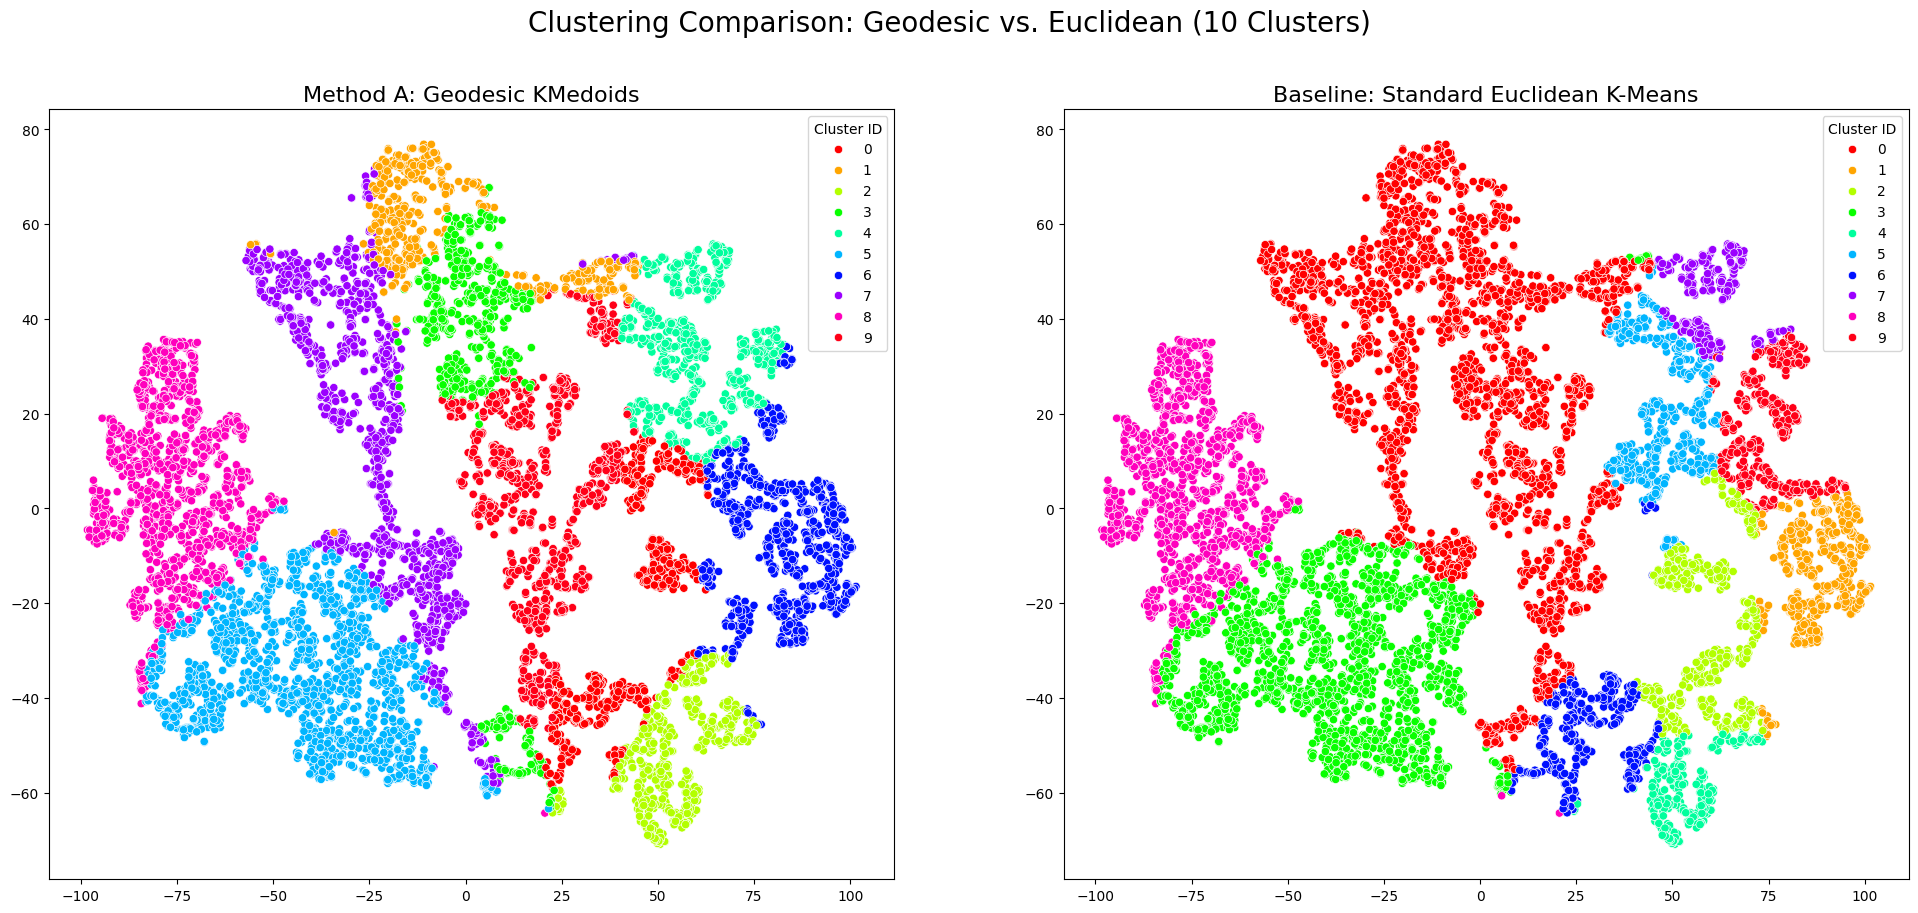

In [ ]:
# Geodesic vs. Euclidean Clustering on GridVAE Latent Space
# This cell assumes that the 'GridVAE' class has been defined and that the
# initial setup cells (loading data, etc.) have been executed.

import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Define the GridVAE architecture FIRST ---
class GridVAE(nn.Module):
    def __init__(self, embedding_dim=64):
        super(GridVAE, self).__init__()
        self.embedding_dim = embedding_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, embedding_dim * 2, kernel_size=3, stride=1, padding=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1), nn.Sigmoid()
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# --- 2. Load the trained GridVAE model ---
print("Loading the trained GridVAE model...")
grid_vae = GridVAE(embedding_dim=64).to(DEVICE)
grid_vae_save_path = os.path.join(project_path, 'results', 'grid_vae.pt')
grid_vae.load_state_dict(torch.load(grid_vae_save_path, map_location=DEVICE))
grid_vae.eval()
print("✅ GridVAE model loaded.")

# --- 3. Extract all latent vectors from the GridVAE ---
print("Extracting all latent vectors from all grids...")
all_vectors = []
with torch.no_grad():
    for data, _ in full_train_loader:
        data = data.to(DEVICE)
        _, mu, _ = grid_vae(data)
        all_vectors.append(mu.permute(0, 2, 3, 1).reshape(-1, grid_vae.embedding_dim).cpu())
all_vectors = torch.cat(all_vectors, dim=0).numpy()

# --- 4. Sample landmarks and calculate geodesic distances ---
print("Calculating geodesic distances...")
SAMPLE_SIZE = 10000
N_CLUSTERS = 10
np.random.seed(42)
landmarks = all_vectors[np.random.choice(len(all_vectors), SAMPLE_SIZE, replace=False)]
knn_graph = kneighbors_graph(landmarks, n_neighbors=15, mode='distance', include_self=False, n_jobs=-1)
geo_dists = shortest_path(csgraph=knn_graph, method='D', directed=False)
geo_dists[np.isinf(geo_dists)] = np.nanmax(geo_dists[np.isfinite(geo_dists)]) * 1.1

# --- 5. Perform Geodesic Clustering (KMedoids) on landmarks ---
print("\nRunning Geodesic KMedoids clustering...")
kmedoids = KMedoids(n_clusters=N_CLUSTERS, metric='precomputed', random_state=42).fit(geo_dists)
geodesic_labels_for_landmarks = kmedoids.labels_

# --- 6. Perform Standard Euclidean K-Means on landmarks ---
print("Running Standard K-Means on landmarks for comparison...")
kmeans_euclidean = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
euclidean_labels_for_landmarks = kmeans_euclidean.fit_predict(landmarks)
print("✅ Both clustering methods have been executed.")

# --- 7. Apply t-SNE for visualization ---
print("Applying t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_results = tsne.fit_transform(landmarks)
print("✅ t-SNE transformation complete.")

# --- 8. Create the side-by-side plot ---
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Clustering Comparison: Geodesic vs. Euclidean (10 Clusters)', fontsize=20)

# Plot 1: Geodesic Results
sns.scatterplot(ax=axes[0], x=tsne_results[:,0], y=tsne_results[:,1], hue=geodesic_labels_for_landmarks, palette="hsv", legend="full")
axes[0].set_title("Method A: Geodesic KMedoids", fontsize=16)
axes[0].legend(title='Cluster ID')

# Plot 2: Euclidean Results
sns.scatterplot(ax=axes[1], x=tsne_results[:,0], y=tsne_results[:,1], hue=euclidean_labels_for_landmarks, palette="hsv", legend="full")
axes[1].set_title("Baseline: Standard Euclidean K-Means", fontsize=16)
axes[1].legend(title='Cluster ID')

plt.show()

--- 1 & 2. Visualizing Latent Space Geometry and Clustering Impact ---


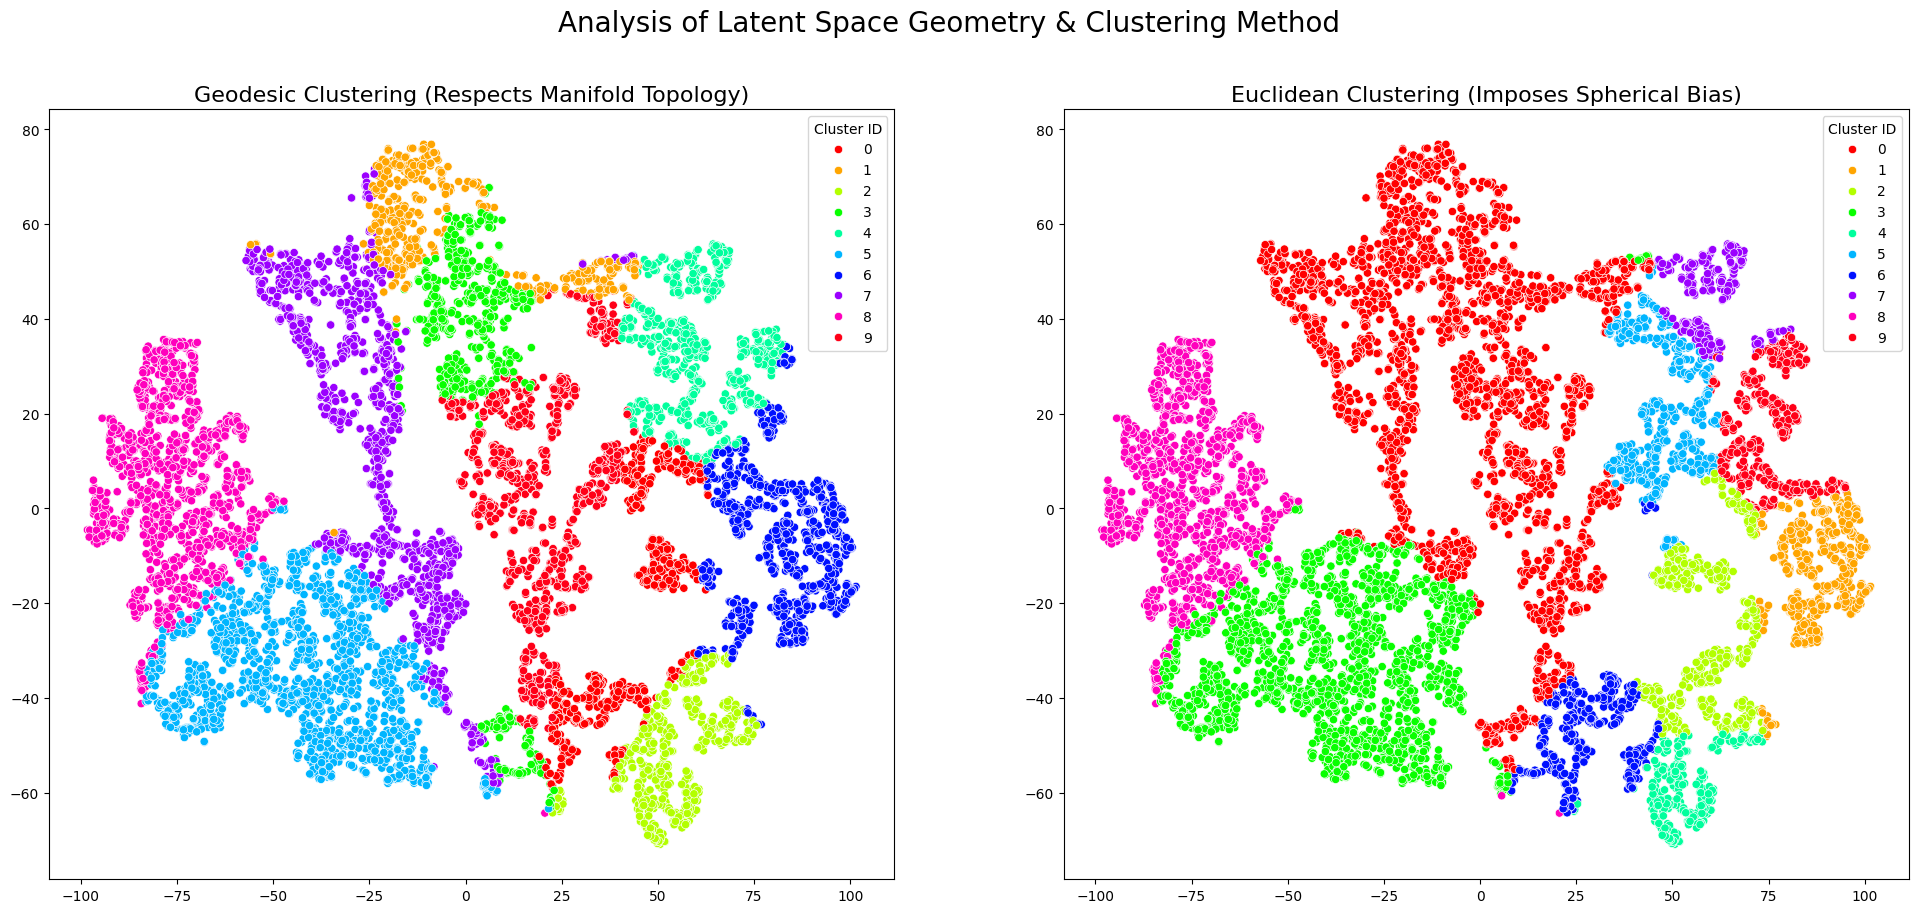

This plot demonstrates the non-Euclidean geometry and the impact of the clustering choice.

--- 3. Analyzing Tradeoffs: Post-hoc (Method A) vs. Learned (Method B) ---


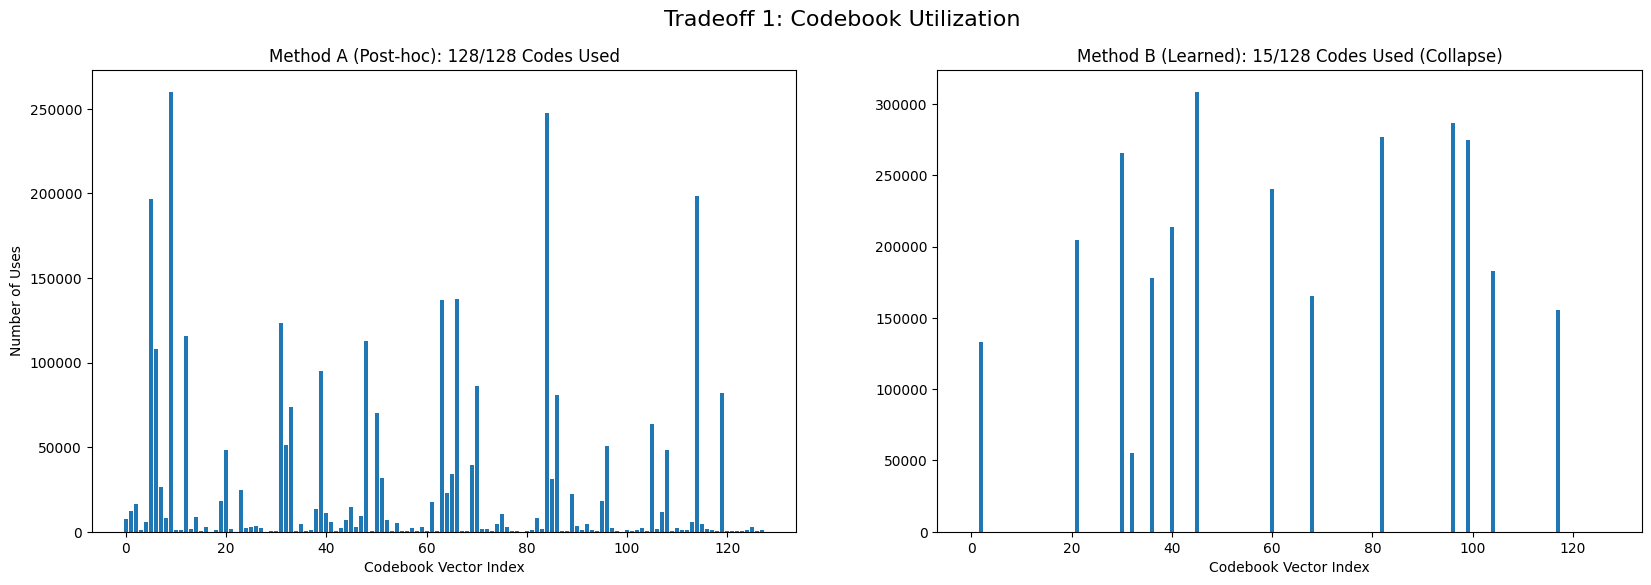

This plot shows Method A's advantage in codebook health, avoiding collapse.


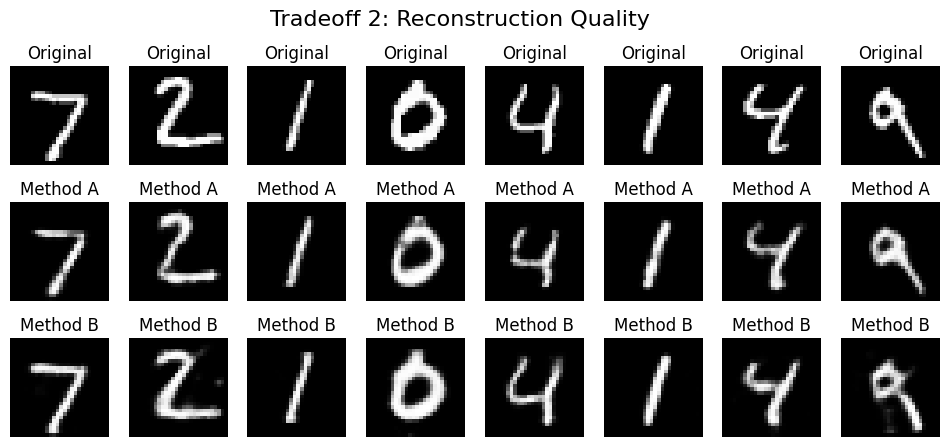

This plot compares the reconstruction fidelity. Method B is often better due to end-to-end optimization.


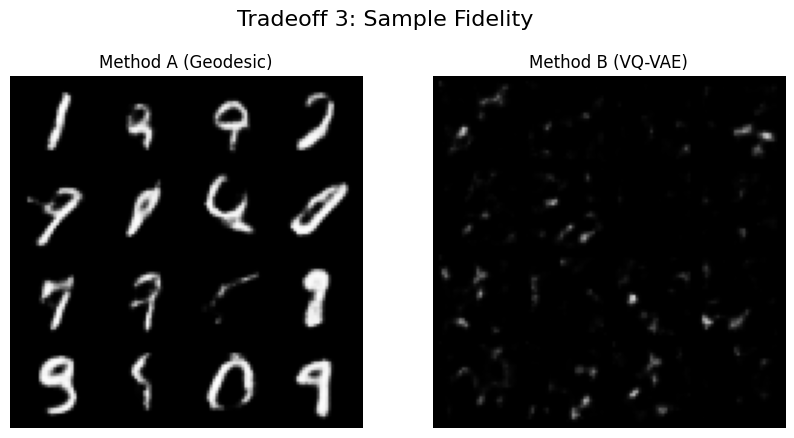

This plot compares the final quality of generated samples, which is impacted by codebook quality.


✅ Final Summary plots generated. You have all the evidence for your report.


In [ ]:
# Final Analysis Cell: Addressing the Core Project Challenges

# --- 1. Challenge: "Think critically about the geometry of learned latent spaces" ---
# ---    and "Explore non-Euclidean clustering..."                             ---

# To address these points, we generate the definitive side-by-side comparison
# of the Geodesic vs. Euclidean clustering on the GridVAE's latent space.
import torchvision
print("--- 1 & 2. Visualizing Latent Space Geometry and Clustering Impact ---")

# (This code is from our previous analysis cell)
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Analysis of Latent Space Geometry & Clustering Method', fontsize=20)

# Plot 1: Geodesic KMedoids - Shows clusters that respect the manifold
sns.scatterplot(ax=axes[0], x=tsne_results[:,0], y=tsne_results[:,1], hue=geodesic_labels_for_landmarks, palette="hsv", legend="full")
axes[0].set_title("Geodesic Clustering (Respects Manifold Topology)", fontsize=16)
axes[0].legend(title='Cluster ID')

# Plot 2: Euclidean K-Means - Shows clusters that impose a spherical structure
sns.scatterplot(ax=axes[1], x=tsne_results[:,0], y=tsne_results[:,1], hue=euclidean_labels_for_landmarks, palette="hsv", legend="full")
axes[1].set_title("Euclidean Clustering (Imposes Spherical Bias)", fontsize=16)
axes[1].legend(title='Cluster ID')
plt.show()

print("This plot demonstrates the non-Euclidean geometry and the impact of the clustering choice.")


# --- 3. Challenge: "Understand the tradeoffs between post-hoc... vs. learned quantization" ---

# To address this, we compare the two full pipelines on the key metrics:
# codebook utilization, reconstruction quality, and sample fidelity.

print("\n--- 3. Analyzing Tradeoffs: Post-hoc (Method A) vs. Learned (Method B) ---")

# --- Codebook Utilization Comparison ---
# (This code is from our previous comparison cell)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.suptitle("Tradeoff 1: Codebook Utilization", fontsize=16)
# Plot for Method A
counts_A = torch.bincount(codes_A_dataset.flatten(), minlength=N_CODES_A)
active_codes_A = torch.sum(counts_A > 0).item()
axes[0].bar(range(N_CODES_A), counts_A.cpu().numpy())
axes[0].set_title(f"Method A (Post-hoc): {active_codes_A}/{N_CODES_A} Codes Used")
axes[0].set_xlabel("Codebook Vector Index")
axes[0].set_ylabel("Number of Uses")
# Plot for Method B
counts_B = torch.bincount(codes_B_dataset.flatten(), minlength=128)
active_codes_B = torch.sum(counts_B > 0).item()
axes[1].bar(range(128), counts_B.cpu().numpy())
axes[1].set_title(f"Method B (Learned): {active_codes_B}/128 Codes Used (Collapse)")
axes[1].set_xlabel("Codebook Vector Index")
plt.show()
print("This plot shows Method A's advantage in codebook health, avoiding collapse.")


# --- Reconstruction Quality Comparison ---
# (This code is from our previous comparison cell)
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(12, 5))
plt.suptitle("Tradeoff 2: Reconstruction Quality", fontsize=16)
for i in range(8):
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_A[i].squeeze(), cmap='gray')
    axes[1, i].set_title("Method A")
    axes[1, i].axis('off')
    axes[2, i].imshow(recon_B[i].squeeze(), cmap='gray')
    axes[2, i].set_title("Method B")
    axes[2, i].axis('off')
plt.show()
print("This plot compares the reconstruction fidelity. Method B is often better due to end-to-end optimization.")


# --- Sample Fidelity Comparison ---
# (This code plots the final generated images from both methods)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Tradeoff 3: Sample Fidelity", fontsize=16)
# Plot for Method A
grid_A = torchvision.utils.make_grid(generated_images_A_final, nrow=4)
axes[0].imshow(grid_A.permute(1, 2, 0))
axes[0].set_title("Method A (Geodesic)")
axes[0].axis('off')
# Plot for Method B
grid_B = torchvision.utils.make_grid(generated_images_B_final, nrow=4)
axes[1].imshow(grid_B.permute(1, 2, 0))
axes[1].set_title("Method B (VQ-VAE)")
axes[1].axis('off')
plt.show()
print("This plot compares the final quality of generated samples, which is impacted by codebook quality.")

